# Siamese Neural Networks for Face Similarity

One particularly interesting task is classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. This is called one-shot learning and it is the primary focus of our model presented in this work (Fei-Fei et al., 2006; Lake et al., 2011)

Siamese networks are neural networks containing two or more identical subnetwork components

Usually, siamese networks perform binary classification at the output, classifying if the inputs are of the same class or not. Hereby, different loss functions may be used during training. One of the most popular loss functions is the binary cross-entropy loss.

Siamese networks are different to traditional neural networks, instead of a model learning to classify its inputs, the neural networks learns to differentiate between two inputs. It learns the similarity between them.

Siamese networks can be used for differents task such text similarity, signature verification (two signatures from the same person) and paraphrase scoring.

In this project I will use Siamese Networks and teach them to distinguish pairs of images. The framework used is PyTorch.  Each class must be in its own folder.

I will use the AT&T faces dataset to train the model. The dataset contains images of 40 subjects from various angles. I downloaded some pictures of celebrities in different angles to test the model.

You can read more about Siamese Neural Network in this paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

# Loading the data

In [31]:
#Unzip the data
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/faces/
   creating: data/faces/testing/
   creating: data/faces/testing/s10/
  inflating: data/faces/testing/s10/1.jpg  
  inflating: data/faces/testing/s10/10.jpg  
  inflating: data/faces/testing/s10/2.jpg  
  inflating: data/faces/testing/s10/3.jpg  
  inflating: data/faces/testing/s10/4.jpg  
  inflating: data/faces/testing/s10/5.jpg  
  inflating: data/faces/testing/s10/6.jpg  
  inflating: data/faces/testing/s10/7.jpg  
  inflating: data/faces/testing/s10/8.jpg  
  inflating: data/faces/testing/s10/9.jpg  
   creating: data/faces/testing/s11/
 extracting: data/faces/testing/s11/1.jpg  
  inflating: data/faces/testing/s11/1.png  
  inflating: data/faces/testing/s11/10.jpg  
  inflating: data/faces/testing/s11/2.jpg  
  inflating: data/faces/testing/s11/3.jpg  
  inflating: data/faces/testing/s11/4.jpg  
  inflating: data/faces/testing/s11/5.jpg  
  inflating: data/faces/testing/s11/6.jpg  
  inflating: data/faces/testing/s11/

# Imports

In [2]:
#Installing libraries
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61d08000 @  0x7f6e8e8812a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 2.0MB 11.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
#Importing libraries
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Helper functions

In [0]:
#Functions we will need later
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Configuration Class

In [0]:
# Creating a class to manage configuration
class Config():
    training_dir = "/content/data/faces/training/"
    testing_dir = "/content/data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 300

# Custom Dataset Class

In [0]:
# This dataset generates a pair of images. 0 for genuine pair and 1 for imposter pair

class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Using Image Folder Dataset

In [0]:
# Using Image Folder Dataset
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

# Visualising some of the data

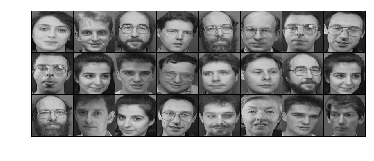

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [55]:
# The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of
# the image. 1 indicates dissimilarity, and 0 indicates similarity. Batch size of 12.

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=12,
                        batch_size=12)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Neural Net Definition

In [0]:
# We will use a standard convolutional neural network

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss

The objective of the siamese network is not to classify input images, but to differentiate between them. So, a classification loss function (such as cross entropy) would not be the best fit. Instead, this architecture is better suited to use a contrastive function. Intuitively, this function just evaluates how well the network is distinguishing a given pair of images.

In [0]:
# Contrastive Loss
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Let's the training begin!

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
# We will use Adam optimizer and a learning rate of 0.0001
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.0144293308258057

Epoch number 1
 Current loss 1.2312577962875366

Epoch number 2
 Current loss 1.2548613548278809

Epoch number 3
 Current loss 1.1317168474197388

Epoch number 4
 Current loss 1.1309149265289307

Epoch number 5
 Current loss 1.119064211845398

Epoch number 6
 Current loss 0.9852163791656494

Epoch number 7
 Current loss 1.0822367668151855

Epoch number 8
 Current loss 1.0868303775787354

Epoch number 9
 Current loss 1.1216230392456055

Epoch number 10
 Current loss 1.2702021598815918

Epoch number 11
 Current loss 1.144930124282837

Epoch number 12
 Current loss 1.136237621307373

Epoch number 13
 Current loss 1.1040713787078857

Epoch number 14
 Current loss 1.1564958095550537

Epoch number 15
 Current loss 1.115474820137024

Epoch number 16
 Current loss 1.1413438320159912

Epoch number 17
 Current loss 1.1880464553833008

Epoch number 18
 Current loss 1.1150070428848267

Epoch number 19
 Current loss 1.1484482288360596

Epoch number 2

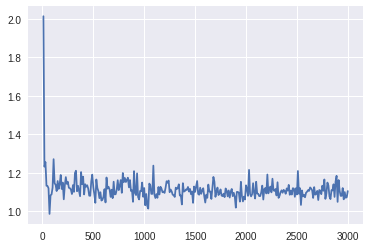

In [62]:
#Let's start the training! we will run 300 epochs!
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

# Let's test the model

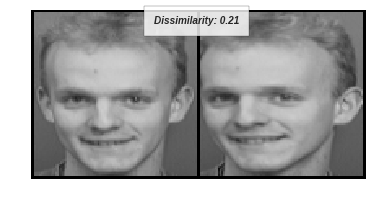

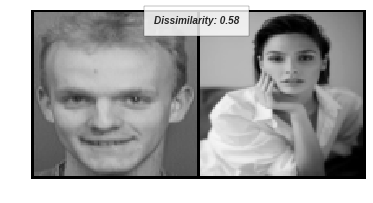

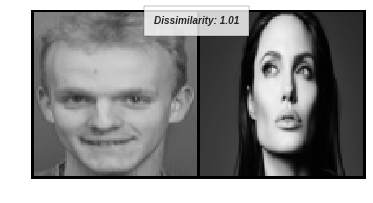

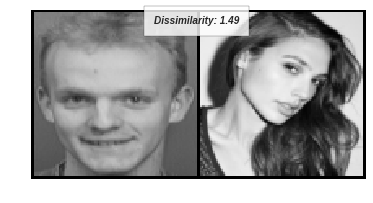

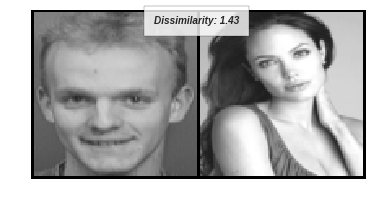

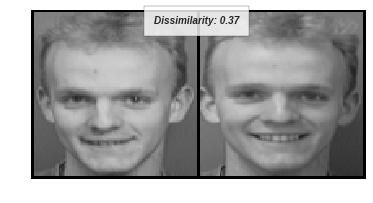

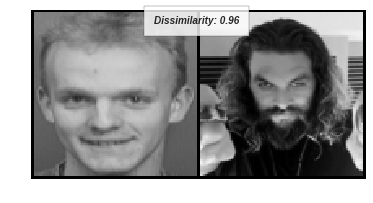

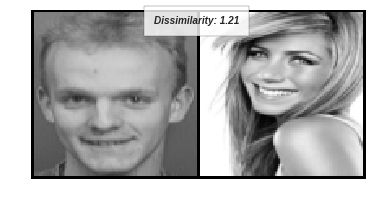

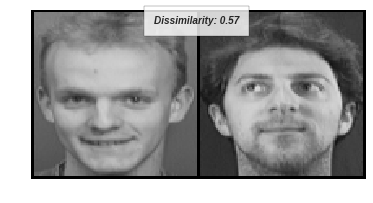

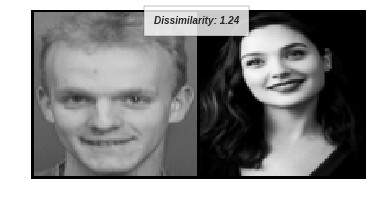

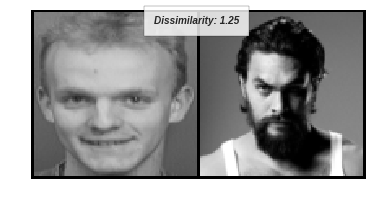

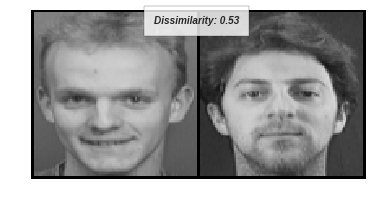

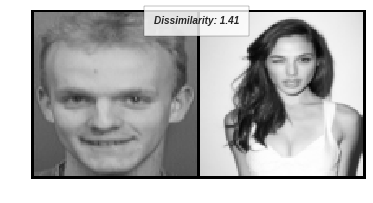

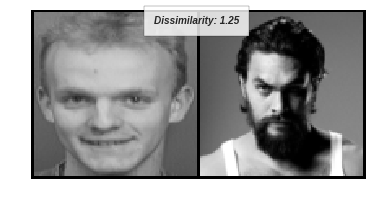

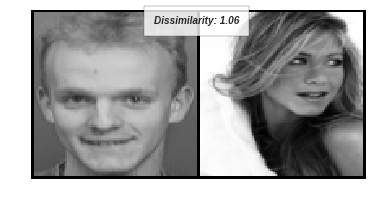

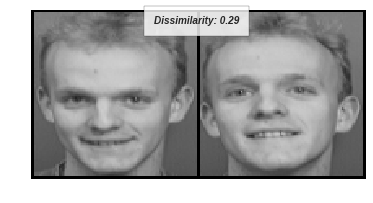

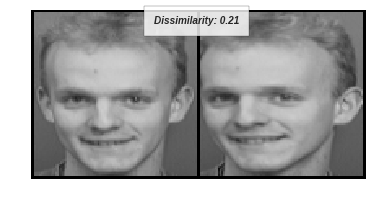

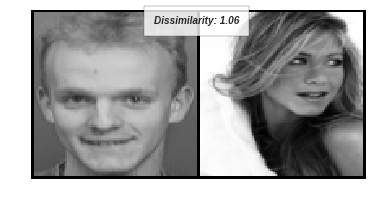

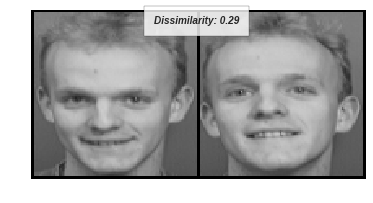

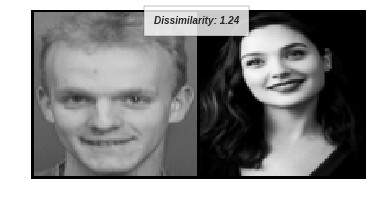

In [84]:
#Data transforms and test some samples
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=12,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(20):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Conclusions

The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.